In [1]:
import pandas as pd #data processing library
import matplotlib as mpl #plotting library
import matplotlib.pyplot as plt
import warnings #library for managing warnings
from IPython.core.display import Image #display images
import numpy as np #base matrix library
import os ##navigate the operating system
import collections as cl #let's me use ordered dictionaries
warnings.filterwarnings('ignore') #hide warnings (aesthetic reasons)

# Overview

We were provided a set of detailed inspection data for one sheet of subarrays, as well as summary statistics for many lots of subarray. In order to better understand the precision with which we need to position our heads.

This notebook has two separate but related analyses:

 - Analysis of the first datafile we received, which contained raw data for a single sheet and summary (OD/ID) data for the past several years of sheets
 - Analysis of 75 sets of raw data that were "randomly" selected by Chris Ravin
 In any case, a sheet of arrays looks like the following
 

In [ ]:
Image('arrays.png') 

# Analysis 1: Single Sheet

First we pull in the data and take a look

In [ ]:
data_loc = r"C:\Users\cloughnane\Desktop\MR118_A.xls" #point to the excel file
df_raw = pd.read_excel(data_loc,"RAW_Data",index_col=0,parse_cols="A:J,M:P") #read excel file into a pandas DataFrame object
df_raw #let's take a look at it!

##  Make the I.D. it's own column

One quirk about the way this data is entered is that the data file has each row alternating ID and OD (as indicated by `1`s and `0`s in the `OD` column. It will be easier for us to parse if it's in an individual column

In [ ]:
df_raw_clean = df_raw[df_raw['OD']==1] # create a dataframe that only contains the OD measurements
df_raw_id = df_raw[df_raw['OD']==0] # create a dataframe that only contains the ID measurements
df_raw_id.index = df_raw_id['Diam mm'].index-1 #adjust the index of the ID dataframe to match that of the OD dataframe
df_raw_clean['ID'] = df_raw_id.loc[:,('Diam mm')] # move the diameter column in the ID dataframe to the OD dataframe

# delete the "OD" columnin the OD dataframe (was just a 0 or 1, identifying if the "Diam mm" filed represented ID or OD
del df_raw_clean['OD'] 

#rename the "Diam mm" column as "OD" so that we now hav ean "ID" and "OD" column
df_raw_clean.rename(columns={'Diam mm': 'OD'}, inplace=True)

#Let's show the new dataframe!
df_raw_clean

## Hole diameters

Let's take a look at standard deviation of the hole diameters, as well as their distributions

In [ ]:
diameters = ['OD','ID'] #list of column names we want stats for
for diameter in diameters: #iterate through the column names
    #print out the standard deviation in a nice format
    print "The standard deviation of the {} is {}".format(diameter,df_raw_clean[diameter].std())
df_raw_clean[['OD','ID']].plot(subplots=True,kind='hist') # plot distributions from dataframe

So the ID is less controlled than the OD, not surprising given that the parts are etched from a mask at the surface.

## Variation in position between holes

In order to fit anything into the holes, we need to see how accurate the alignment is. To get at that, first let's create columns that redefine X and Y relative to their first dimension.

This means that in order to calculate the variation in holes, we need to find a zero for each open array

In [2]:
def relative_position(df,xlabel="X mm", ylabel="Y mm",oaid = "OA number",inplace=True):
    '''
    Calculates the position of each hole in a subarray relative to it's first hole
    
    df: dataframe containing absolute X and Y positions, as well an open array iD
    xlabel: The heading of the column containing absolute x positions
    ylabel: The heading of the column containing absolute y positions
    oaid: The heading of the column containing the Open Array number
    inplace: True if modify df in place, if False returns dataframe with relative positions
    '''
    oa_numbers = df[oaid].unique() #pull the list of OA numbers
    for i,oa_number in enumerate(oa_numbers): # iterate through the list of OA numbers, also, keep track of if which one we're on
        oa_subset=df_raw_clean[df_raw_clean[oaid]==oa_number] #pull out the values for the current OA
        x_start = oa_subset.iloc[0][xlabel] #find the first x value
        y_start = oa_subset.iloc[0][ylabel] #find the y value
        if i==0: #if this is the first OA we are looking at
            x_rel = oa_subset[xlabel]-x_start #create a series that is a copy of the X position series less the starting point
            y_rel = oa_subset[ylabel]-y_start #create a series that is a copy of the Y position series less the starting point
        else: # if this is the second or later OA we are looking at
            x_rel = x_rel.append(oa_subset[xlabel]-x_start) #calculate relative x positions for array and add it to prev positions
            y_rel = y_rel.append(oa_subset[ylabel]-y_start) #calculate relative x positions for array and add it to prev positions
    if inplace==True:
        df_raw_clean['X_rel']=x_rel #add the relative x measurements to the dataframe
        df_raw_clean['Y_rel']=y_rel #add the relative y measurements to the dataframe
    else:
        return pd.concat((x_rel,y_rel),axis=1)

Now that we've calculated the relative positions of each, let's combine them into the [OG](http://www.urbandictionary.com/define.php?term=OG) dataframe

In [ ]:
relative_position(df_raw_clean)#calculate the relative position
df_raw_clean

Because we know the pitch is supposed to be **`0.500mm`**, we can characterize variation as how far off each number is from the nearest **`0.500mm`** increment

In [3]:
def relative_delta(df,nearest=0.5,xlabel="X_rel",ylabel="Y_rel"):
    axes = [('X_delta',xlabel),('Y_delta',ylabel)] #names of of relative columns and (new) delta columns for each axis
    for delta,rel in axes: # iterate through the axis
        split = nearest/2 #define a split point
        neg = df[rel]%nearest-nearest #an appropriate calculation for negative offsets
        neg = neg[neg.abs()<split] #filter to keep only negative offsets
        pos = df[rel]%nearest # an appropriate calculation for positive offsets
        pos = pos[pos.abs()<split] #filter to keep only positive offsets
        df[delta] = neg.append(pos).sort_index() #combine the two sets and sort them by the index
    df['true position'] = (df['X_delta']**2+df['Y_delta']**2)**0.5

In [ ]:
relative_delta(df_raw_clean)
df_raw_clean

Let's take a look at the distributions

In [ ]:
deltas = ['X_delta','Y_delta'] #list of deltas for which we want to calculate sigma
for delta in deltas: #iterate through the deltas
    print "The standard deviation of the {} is {}".format(delta,df_raw_clean[delta].std()) #print sigma
df_raw_clean[deltas].plot(subplots=True,kind='hist')

Interesting...it looks like both are pretty on point, but `Y_delta` is more dispersed. Let's calculate sigma to look deeper into it

Sure enough we are seeing a standard deviation on the Y_delta at **`4.7µm`**.Let's take a look at the variations plotted spatially.

First, to make sure everything looks ok, let's plot everything just on the X and Y axis in a simple scatterplot. Also, we'll make the figure size square and set the x and y axes to the same size

In [ ]:
xlim = (0,150)
ylim = (-150,0)
figsize = (10,10)
df_raw_clean.plot(kind='scatter',x='X mm',y='Y mm',s=100,figsize=figsize,xlim=xlim,ylim=ylim)

Everything looks pretty straightforward, now let's add a column that takes the magnitude of the X and Y offset, and then use that mangnitude to make a bubble chart

In [ ]:
a=df_raw_clean['X_delta']
a

In [ ]:
df_raw_clean['true position'] = (df_raw_clean['X_delta']**2+df_raw_clean['Y_delta']**2)**0.5
sizes = df_raw_clean['X_delta']*100
df_raw_clean.plot(kind='scatter',x='X mm',y='Y mm',s=100,c=mpl.cm.seismic(sizes),figsize=figsize,xlim=xlim,ylim=ylim,alpha=0.5)

In [ ]:
mymap = plt.get_cmap

Interestingly, it seems like the magnitude of delta gets bigger. I think there are a bunch of ways to slice this, but to be conservative I'll just look at the largest variation across an array.

In [ ]:
summary_sigma = df_raw_clean.groupby('OA number').std()['true position']
summary_x = df_raw_clean.groupby('OA number').mean()['X mm']
summary_y = df_raw_clean.groupby('OA number').mean()['Y mm']
df_summary = pd.concat([summary_sigma,summary_x,summary_y],axis=1)
df_summary.rename(columns={'true position':'sigma'},inplace=True)
df_summary.plot(kind='scatter',x='X mm',y='Y mm',s=df_summary['sigma']*1000000)

In [ ]:
df_summary

Here we can see the max sigma is **`0.0043`**

If we compare the overall sigma of this inspection to the historical data we should get a sense for where this inspection report fits overall. So let's load in the historical data

In [ ]:
# df_log1 = pd.read_excel(data_loc,"LOG",index_col=0,parse_cols="A:T")
df_log2 = pd.read_excel(data_loc,"LOG2",index_col='Open Array')

Let's look at the data

In [ ]:
df_log2

Let's plot the data to see where things fall

In [ ]:
df_log2.plot(x='Date',y='OD sd',kind='line',ylim=(0,0.02))

Anecdotally, looking at this it looks like most arrays that don't fail have a max of around **`0.015`** The inspection report calls some of the items failures (so that should exclude that spikes). To be more precise would require more analysis

Done!

# More data

Chris Ravin supplied us with a bunch more inspection data, so let's look at that. First we point to the directory with all the files

In [ ]:
# data_loc = r"P:\4143-Blackburn\Transfer\Inbound\micro vu files"
data_loc = r"P:\4143-Blackburn\Transfer\Inbound\hole size measurement files"
datafiles = [datafile.split('.')[0] for datafile in os.listdir(data_loc) if datafile.split('.')[-1]=='txt']
df_log = pd.read_excel("\\".join((data_loc,'MR118_A.xlsm')),sheetname='LOG')

In [ ]:
mask = (df_log['Vol SD % P/F']=='Fail') | (df_log['Vol Avg P/F']=='Fail')
failures = df_log[mask].Code.values

In [ ]:
passing = [datafile for datafile in datafiles if not datafile in failures]

Next let's put them all in a big dataframe. We'll also only look at the first 384 rows because there is some footer information at the end (and they all appear to be the same length)

In [ ]:
# for failure in failures:
#     if failure in datafiles:
#         print failure

In [ ]:
col_names = ['X mm',"Y mm","Diameter", "Circularity"]
num_files = len(passing)
for i,datafile in enumerate(passing):
    if i%500==0:
        print "Processing file {} of {}".format(i,num_files)
    path = '.'.join((datafile,'txt'))
    code = datafile
    try:
        if i==0:
            df = pd.read_table("\\".join((data_loc,path)),header=None,names=col_names,nrows=384)
            df['Code']=code
        else:
            df_temp = pd.read_table("\\".join((data_loc,path)),header=None,names=col_names,nrows=384)
            df_temp['Code']=code
            df = df.append(df_temp,ignore_index=True)
    except:
        print "could not process {}".format(datafile)
    

Because of the way these are measured, the OD and ID measurements exist as separate columns. This cna be shown by a quick histogram

In [4]:
df = pd.read_csv('hole_data_raw.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000006AE5208>]], dtype=object)

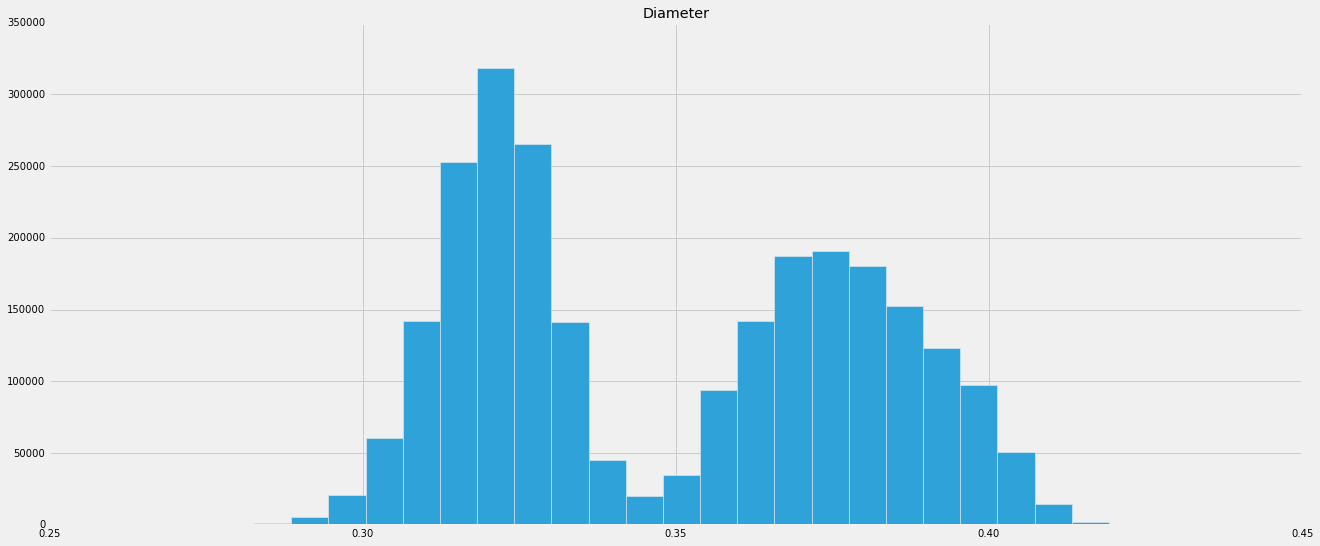

In [5]:
df.hist('Diameter',bins=30)

So let's clean that up so that each row is a hole and there is a column for OD and ID. It looks like we can split it at `0.35`

In [7]:
df_id = df[df['Diameter'] <0.35] # create a dataframe that only contains the ID measurements
df = df[df['Diameter'] >=0.35] # create a dataframe that only contains the OD measurements
df_id.index = df_id['Diameter'].index-1 #adjust the index of the ID dataframe to match that of the OD dataframe
df['ID'] = df_id.loc[:,('Diameter')] # move the diameter column in the ID dataframe to the OD dataframe
df.rename(columns={"Diameter":"OD"},inplace=True)
df

,Unnamed: 0,X mm,Y mm,OD,Circularity,Code,ID
0,0,12.482,-1.007,0.372,0.010,0508,0.311
2,2,13.981,-2.503,0.378,0.014,0508,0.319
4,4,14.482,-3.003,0.379,0.006,0508,0.319
6,6,15.982,-4.502,0.374,0.013,0508,0.302
8,8,34.987,-5.504,0.375,0.006,0508,0.312
10,10,36.486,-7.004,0.379,0.012,0508,0.310
12,12,36.985,-7.506,0.376,0.007,0508,0.301
14,14,38.486,-8.998,0.374,0.014,0508,0.306
16,16,39.487,-9.999,0.374,0.010,0508,0.303
18,18,40.987,-11.501,0.378,0.008,0508,0.316


So that looks pretty good, but it would be really convenient if we were able to have a column indicating the `oa row` and `oa col` like we have above. Fortunately, we can just copy the way it's done in the excel file that was originally provided`

In [8]:
df_oaref = pd.read_excel(r"C:\Users\cloughnane\Desktop\MR118_A.xls",sheetname="RAW_Data",skiprows=23,parse_cols="U:Y",nrows=6)[:6]
df_oaref

,OA row,ymin,ymax,avg,wide
0,1,0,-17,-8.5,8.5
1,2,-23,-40,-31.5,8.5
2,3,-49,-66,-57.5,8.5
3,4,-72,-89,-80.5,8.5
4,5,-98,-115,-106.5,8.5
5,6,-121,-138,-129.5,8.5


In [9]:

col_bins = cl.OrderedDict()
col_bins['c7']=-1000
col_bins['c6']=-121
col_bins['c5']=-97
col_bins['c4']=-71
col_bins['c3']=-48
col_bins['c2']=-22
col_bins['c1']=1
row_bins = cl.OrderedDict()
row_bins['r3']=-1
row_bins['r2']=65
row_bins['r1']=1000


In [10]:
col_edges = [j for i,j in col_bins.iteritems()]
col_labels = [int(i[1]) for i,j in col_bins.iteritems()]
oa_col = pd.cut(df['Y mm'],col_edges,labels=col_labels[1:]).astype(int)

row_edges = [j for i,j in row_bins.iteritems()]
row_labels = [int(i[1]) for i,j in row_bins.iteritems()]
oa_row = pd.cut(df['X mm'].astype(float),row_edges,labels=row_labels[1:]).astype(int)

In [11]:
df['oa col'] = oa_col.values
df['oa row'] = oa_row.values
df

,Unnamed: 0,X mm,Y mm,OD,Circularity,Code,ID,oa col,oa row
0,0,12.482,-1.007,0.372,0.010,0508,0.311,1,2
2,2,13.981,-2.503,0.378,0.014,0508,0.319,1,2
4,4,14.482,-3.003,0.379,0.006,0508,0.319,1,2
6,6,15.982,-4.502,0.374,0.013,0508,0.302,1,2
8,8,34.987,-5.504,0.375,0.006,0508,0.312,1,2
10,10,36.486,-7.004,0.379,0.012,0508,0.310,1,2
12,12,36.985,-7.506,0.376,0.007,0508,0.301,1,2
14,14,38.486,-8.998,0.374,0.014,0508,0.306,1,2
16,16,39.487,-9.999,0.374,0.010,0508,0.303,1,2
18,18,40.987,-11.501,0.378,0.008,0508,0.316,1,2


In [12]:
df['oa number'] = (df['oa row']-1)*6+df['oa col']
df

,Unnamed: 0,X mm,Y mm,OD,Circularity,Code,ID,oa col,oa row,oa number
0,0,12.482,-1.007,0.372,0.010,0508,0.311,1,2,7
2,2,13.981,-2.503,0.378,0.014,0508,0.319,1,2,7
4,4,14.482,-3.003,0.379,0.006,0508,0.319,1,2,7
6,6,15.982,-4.502,0.374,0.013,0508,0.302,1,2,7
8,8,34.987,-5.504,0.375,0.006,0508,0.312,1,2,7
10,10,36.486,-7.004,0.379,0.012,0508,0.310,1,2,7
12,12,36.985,-7.506,0.376,0.007,0508,0.301,1,2,7
14,14,38.486,-8.998,0.374,0.014,0508,0.306,1,2,7
16,16,39.487,-9.999,0.374,0.010,0508,0.303,1,2,7
18,18,40.987,-11.501,0.378,0.008,0508,0.316,1,2,7


In [13]:
oa_numbers = df['oa number'].unique() #pull the list of OA numbers
for i,oa_number in enumerate(oa_numbers): # iterate through the list of OA numbers, also, keep track of if which one we're on
    oa_subset=df[df['oa number']==oa_number] #pull out the values for the current OA
    x_start = float(oa_subset.iloc[0]['X mm']) #find the first x value
    y_start = float(oa_subset.iloc[0]['Y mm']) #find the y value
    if i==0: #if this is the first OA we are looking at
        x_rel = oa_subset['X mm'].astype(float)-x_start #create a series that is a copy of the X position series less the starting point
        y_rel = oa_subset['Y mm'].astype(float)-y_start #create a series that is a copy of the Y position series less the starting point
    else: # if this is the second or later OA we are looking at
        x_rel = x_rel.append(oa_subset['X mm'].astype(float)-x_start) #calculate relative x positions for array and add it to prev positions
        y_rel = y_rel.append(oa_subset['Y mm'].astype(float)-y_start) #calculate relative x positions for array and add it to prev positions


In [14]:
df['X_rel']=x_rel #add the relative x measurements to the dataframe
df['Y_rel']=y_rel #add the relative y measurements to the dataframe

#let's take a look!
relative_delta(df)
df

,Unnamed: 0,X mm,Y mm,OD,Circularity,Code,ID,oa col,oa row,oa number,X_rel,Y_rel,X_delta,Y_delta,true position
0,0,12.482,-1.007,0.372,0.010,0508,0.311,1,2,7,0.000,0.000,0.000,0.000000e+00,0.000000
2,2,13.981,-2.503,0.378,0.014,0508,0.319,1,2,7,1.499,-1.496,-0.001,4.000000e-03,0.004123
4,4,14.482,-3.003,0.379,0.006,0508,0.319,1,2,7,2.000,-1.996,0.000,4.000000e-03,0.004000
6,6,15.982,-4.502,0.374,0.013,0508,0.302,1,2,7,3.500,-3.495,0.000,5.000000e-03,0.005000
8,8,34.987,-5.504,0.375,0.006,0508,0.312,1,2,7,22.505,-4.497,0.005,3.000000e-03,0.005831
10,10,36.486,-7.004,0.379,0.012,0508,0.310,1,2,7,24.004,-5.997,0.004,3.000000e-03,0.005000
12,12,36.985,-7.506,0.376,0.007,0508,0.301,1,2,7,24.503,-6.499,0.003,1.000000e-03,0.003162
14,14,38.486,-8.998,0.374,0.014,0508,0.306,1,2,7,26.004,-7.991,0.004,9.000000e-03,0.009849
16,16,39.487,-9.999,0.374,0.010,0508,0.303,1,2,7,27.005,-8.992,0.005,8.000000e-03,0.009434
18,18,40.987,-11.501,0.378,0.008,0508,0.316,1,2,7,28.505,-10.494,0.005,6.000000e-03,0.007810


In [15]:
#for both X and Y, calculate the remainder of the position when it is divided by 5, as well as 0.5 less said
#remainder. Then take the minimum of that. Poorly worded.... code below :)

axes = [('X_delta','X_rel'),('Y_delta','Y_rel')] #names of of relative columns and (new) delta columns for each axis
for delta,rel in axes: # iterate through the axis
    split = 0.25 #define a split point
    neg = df[rel]%0.5-.5 #an appropriate calculation for negative offsets
    neg = neg[neg.abs()<split] #filter to keep only negative offsets
    pos = df[rel]%0.5 # an appropriate calculation for positive offsets
    pos = pos[pos.abs()<split] #filter to keep only positive offsets
    df[delta] = neg.append(pos).sort_index() #combine the two sets and sort them by the index

#Check out the dataframe!
df

,Unnamed: 0,X mm,Y mm,OD,Circularity,Code,ID,oa col,oa row,oa number,X_rel,Y_rel,X_delta,Y_delta,true position
0,0,12.482,-1.007,0.372,0.010,0508,0.311,1,2,7,0.000,0.000,0.000,0.000000e+00,0.000000
2,2,13.981,-2.503,0.378,0.014,0508,0.319,1,2,7,1.499,-1.496,-0.001,4.000000e-03,0.004123
4,4,14.482,-3.003,0.379,0.006,0508,0.319,1,2,7,2.000,-1.996,0.000,4.000000e-03,0.004000
6,6,15.982,-4.502,0.374,0.013,0508,0.302,1,2,7,3.500,-3.495,0.000,5.000000e-03,0.005000
8,8,34.987,-5.504,0.375,0.006,0508,0.312,1,2,7,22.505,-4.497,0.005,3.000000e-03,0.005831
10,10,36.486,-7.004,0.379,0.012,0508,0.310,1,2,7,24.004,-5.997,0.004,3.000000e-03,0.005000
12,12,36.985,-7.506,0.376,0.007,0508,0.301,1,2,7,24.503,-6.499,0.003,1.000000e-03,0.003162
14,14,38.486,-8.998,0.374,0.014,0508,0.306,1,2,7,26.004,-7.991,0.004,9.000000e-03,0.009849
16,16,39.487,-9.999,0.374,0.010,0508,0.303,1,2,7,27.005,-8.992,0.005,8.000000e-03,0.009434
18,18,40.987,-11.501,0.378,0.008,0508,0.316,1,2,7,28.505,-10.494,0.005,6.000000e-03,0.007810


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AB7EC50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000002516BBE0>], dtype=object)

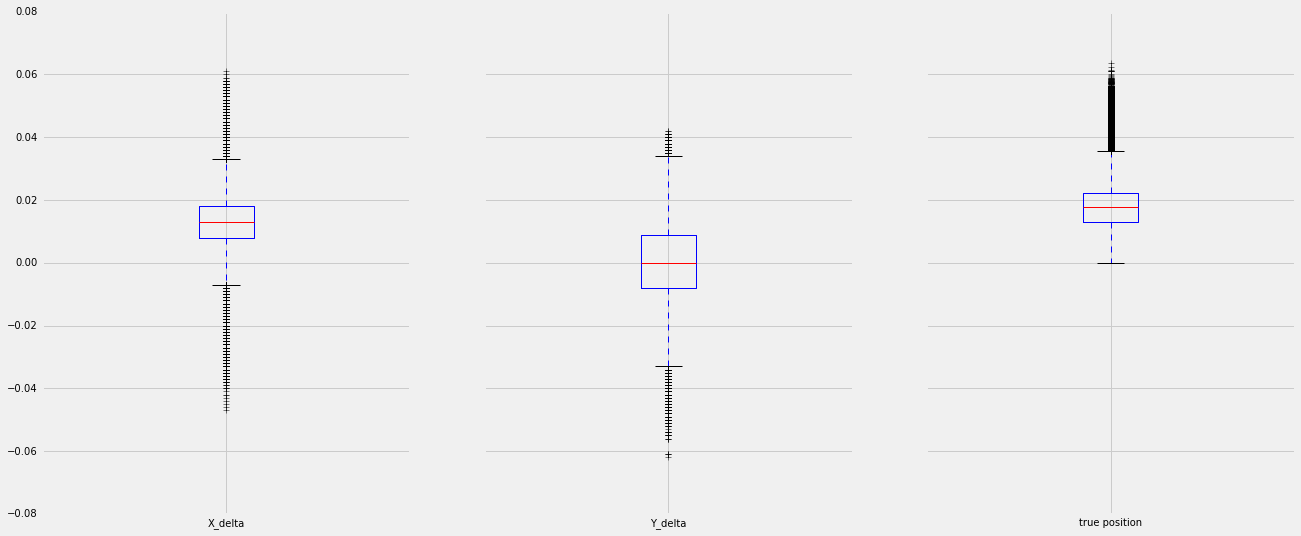

In [16]:
df[['X_delta','Y_delta','true position']].plot(subplots=True,kind='box',sharey=True)

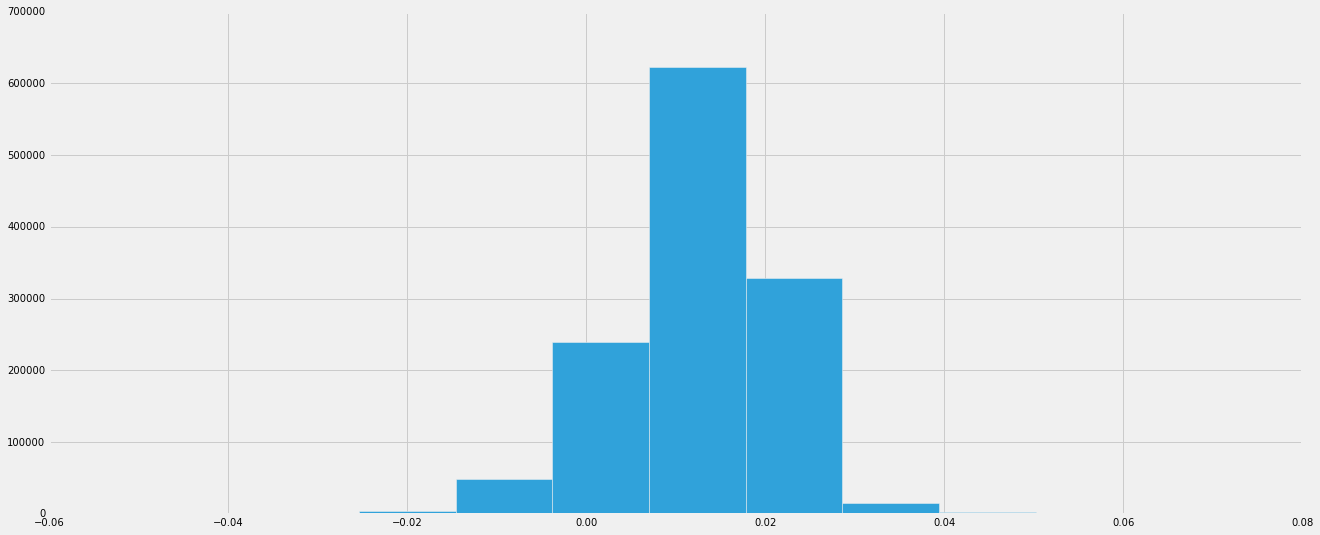

In [17]:
df.X_delta.hist()

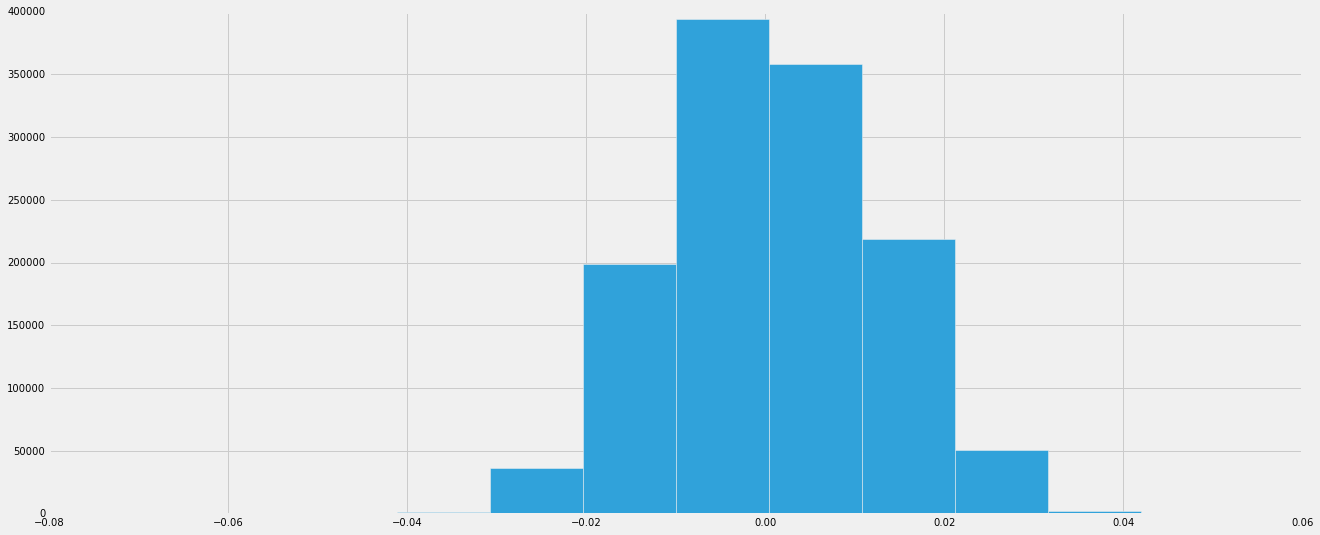

In [18]:
df.Y_delta.hist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C282EF0>], dtype=object)

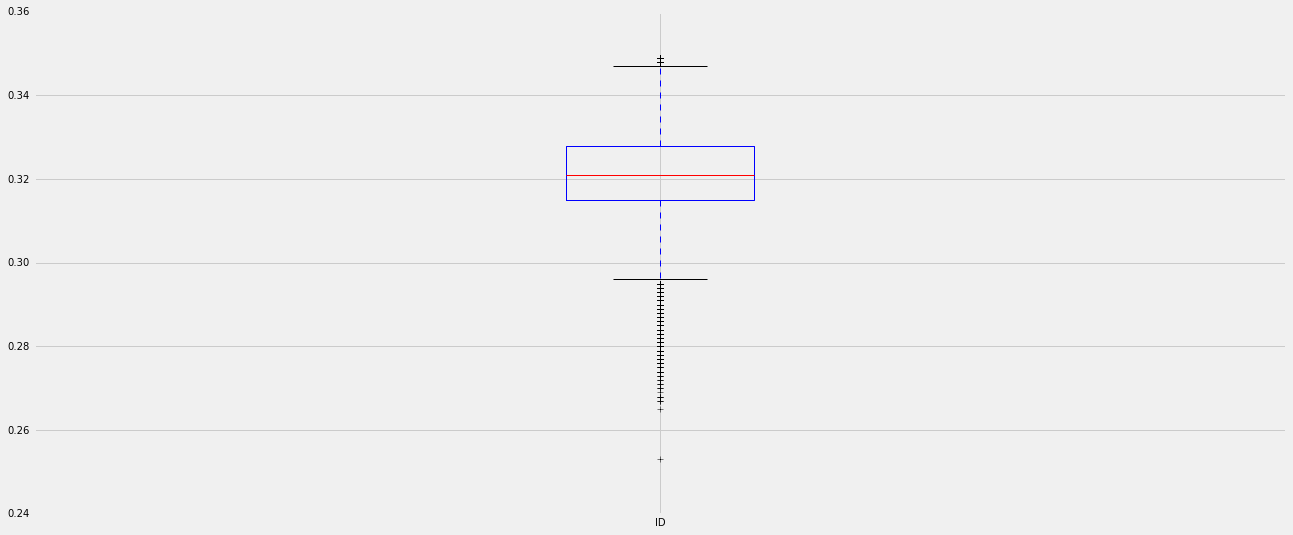

In [19]:
df['ID'].plot(subplots=True,kind='box',sharey=True)

In [20]:
deltas = ['X_delta','Y_delta','true position','OD','ID'] #list of deltas for which we want to calculate sigma
for delta in deltas: #iterate through the deltas
    print "The standard deviation of the {} is {}".format(delta,df[delta].std()) #print sigma
    print "The range of the {} is {} to {}".format(delta,df[delta].min(),df[delta].max()) #print sigma
    print "The mean of the {} is {}".format(delta,df[delta].mean()) #print sigma
    print ""

The standard deviation of the X_delta is 0.00835955186081
The range of the X_delta is -0.047 to 0.061
The mean of the X_delta is 0.0123993379309

The standard deviation of the Y_delta is 0.0117710598272
The range of the Y_delta is -0.062 to 0.042
The mean of the Y_delta is 0.000777500903254

The standard deviation of the true position is 0.00700443339404
The range of the true position is 0.0 to 0.0636553218514
The mean of the true position is 0.0177123073623

The standard deviation of the OD is 0.0139900783301
The range of the OD is 0.35 to 0.431
The mean of the OD is 0.378014172366

The standard deviation of the ID is 0.00956823919366
The range of the ID is 0.253 to 0.349
The mean of the ID is 0.321103421813



In [21]:
# df['true position'] = (df['X_delta']**2+df['Y_delta']**2)**0.5
# # sizes = range(len(df['true position'])*100000
# sizes=[100]*len(df.X_delta)
# # plt.Circle((0,0),r,color='r',fill=False,lw=5)
# a=df.plot(kind='scatter',x='X_delta',y='Y_delta',alpha=0.01,s=sizes,xlim=(-.25,.25),ylim=(-0.25,0.25),figsize=(10,10))
# # a.add_artist(circle)
# # a.add_artist(circle2)

In [22]:
std = df['true position'].std()
std

0.0070044333940377226

In [23]:
df.drop(['X mm','Y mm','Circularity','Code','ID','oa col','oa row','oa number','X_rel','Y_rel','true position'],1,inplace=True)

In [25]:
from sklearn.cluster import KMeans

ImportError: No module named sklearn.cluster

In [24]:
df

,Unnamed: 0,OD,X_delta,Y_delta
0,0,0.372,0.000,0.000000e+00
2,2,0.378,-0.001,4.000000e-03
4,4,0.379,0.000,4.000000e-03
6,6,0.374,0.000,5.000000e-03
8,8,0.375,0.005,3.000000e-03
10,10,0.379,0.004,3.000000e-03
12,12,0.376,0.003,1.000000e-03
14,14,0.374,0.004,9.000000e-03
16,16,0.374,0.005,8.000000e-03
18,18,0.378,0.005,6.000000e-03


In [ ]:
# df = df.drop_duplicates()

In [ ]:
df.OD.iloc[1]

In [ ]:
plt.figure(figsize=(20,20))
ax2=plt.gca(xlim=(-.30,.30),ylim=(-0.30,0.30))
tip_dia=0.1
conc = 0.1
tip_dia_tol=0.018
body_dia_tol=0.007
pin_clearance = 0.022
base_hole_dia_tol=0.01
base_hole_spacing_tol=0.01

diameters = [tip_dia,
             tip_dia_tol,
             conc,
             body_dia_tol,
             pin_clearance,
             base_hole_dia_tol,
             base_hole_spacing_tol]


for i in xrange(len(df)):
    if i % 100000 == 0:
        print "Processing hole # {}".format(i)
    x=df.X_delta.iloc[i]
    y=df.Y_delta.iloc[i]
    od=float(df.OD.iloc[i])
    circle=plt.Circle((x,y),od/2,color='r',fill=False,lw=5,alpha=0.1)
    ax2.add_artist(circle)
    

total=0
for i,diameter in enumerate(diameters):
    total=total+diameter
    circle=plt.Circle((0,0),total/2,color='b',fill=True,lw=5,alpha=0.1)
    ax2.add_artist(circle)
    plt.savefig('{}.png'.format(i))
                     

In [ ]:
df